In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
import pytorch_lightning as pl
from torch.nn.parameter import Parameter
from torchmetrics import PeakSignalNoiseRatio
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import datetime, random
import csv
import os
import argparse
from models import CondEnergyModel
from ResNet import IGEBM
from utils import permute, to_numpy, init_weights, Self_Energy_log, get_dataloaders
from utils import gaussian_noise, sp_noise, delete_square, generate_Y0

# ======================================================================
# Input arguments
# ======================================================================
parser = argparse.ArgumentParser()
parser.add_argument("--name", type=str, default='LD_test')
parser.add_argument("--dataset", type=str, default="CIFAR10")
parser.add_argument("--train_size", type=int, default=60000)
parser.add_argument("--test_size", type=int, default=10000)

parser.add_argument("--in_channel", type=int, default=3)
parser.add_argument("--img_size", type=int, default=64)
parser.add_argument("--dim_feature", type=int, default=32)

parser.add_argument("--gaussian_noise", type=float, default=0.45)
parser.add_argument("--sp_noise", type=float, default=0.1)
parser.add_argument("--square_pixels", type=int, default=20)
parser.add_argument("--degradation", type=str, default='gaussian_noise')
parser.add_argument("--Y0_type", type=str, default='random')

parser.add_argument("--lr_energy_model", type=float, default=0.0001)
parser.add_argument("--lr_langevin_min", type=float, default=0.00005)
parser.add_argument("--lr_langevin_max", type=float, default=0.00008)
parser.add_argument("--number_step_langevin", type=int, default=30)

parser.add_argument("--use_energy_sched", action="store_true", default=False)
parser.add_argument("--use_subset", action="store_true", default=True)
parser.add_argument("--use_label", type=int, default=4)

parser.add_argument("--epochs", type=int, default=100)
parser.add_argument("--save_plot", type=int, default=20)
parser.add_argument("--batch_size", type=int, default=64)

parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")

parser.add_argument("--train_ratio", type=float, default=1.0)
parser.add_argument("--use_unpaired", action="store_true", default=False)
parser.add_argument("--regular_data", type=float, default=0.0)
parser.add_argument("--init_noise_decay", type=float, default=1.0)
# parser.add_argument("--use_gp", action="store_true", default=True)
# parser.add_argument("--use_energy_reg", action="store_true", default=False)
parser.add_argument("--energy_reg_weight", type=float, default=0.0005)
# parser.add_argument("--use_energy_L2_reg", action="store_true", default=True)
parser.add_argument("--use_en_L2_reg", type=float, default=0.0)

args = parser.parse_args(args=[])



In [2]:
inception_model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /home/minhyeok/.cache/torch/hub/v0.10.0.zip
/hdd1/anaconda/minhyeok/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/hdd1/anaconda/minhyeok/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /home/minhyeok/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:02<00:00, 39.8MB/s

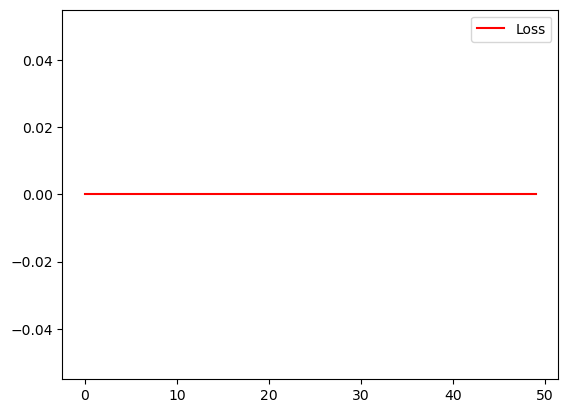

In [4]:
val_psnr_std               = np.zeros(100)


plt.plot(val_psnr_std[:50], color='red', label='Loss')
plt.legend()
plt.show()

In [70]:

# ======================================================================
# Options
# ======================================================================
# curr_dir_path         = os.path.join(os.path.dirname(os.path.abspath('')), '..', 'experiments')
dir_work              = '/nas/users/minhyeok/energy_based_model/experiments'
name                  = args.name
# dir_work              = os.path.join(curr_dir_path, name)
cuda_device           = 0
NGPU                  = torch.cuda.device_count()
device                = torch.device(f'cuda:{cuda_device}' if torch.cuda.is_available() else 'cpu')
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '0, 1, 2, 3'
batch_size            = args.batch_size
number_epoch          = args.epochs
use_energy_sched      = args.use_energy_sched
sched_step_size       = 10
sched_gamma           = 0.93
lr_energy_model       = args.lr_energy_model
lr_langevin_max       = args.lr_langevin_max
lr_langevin_min       = args.lr_langevin_min
number_step_langevin  = args.number_step_langevin
regular_data          = args.regular_data
init_noise_decay      = args.init_noise_decay
# use_reg               = args.use_energy_reg
reg_weight            = args.energy_reg_weight
# use_L2_reg            = args.use_energy_L2_reg
L2_reg_weight         = args.use_en_L2_reg
add_noise             = True
use_unpaired          = args.use_unpaired
in_channel            = args.in_channel
dim_feature           = args.dim_feature
dim_output            = 1
degradation           = args.degradation
Y0_type               = args.Y0_type
sigma_noise           = args.gaussian_noise
snp_noise             = args.sp_noise
square_pixels         = args.square_pixels
# use_gp                = args.use_gp
seed                  = 0
list_lr_langevin      = np.linspace(lr_langevin_max, lr_langevin_min, num=number_epoch, endpoint=True)
pl.seed_everything(0)

# ======================================================================
# Dataset 
# ======================================================================
# dir_data    = os.path.join(dir_work, 'data')
dir_data = '/hdd1/dataset'
dir_dataset = args.dataset
im_size     = args.img_size
scale_range = [-1, 1]
train_size  = args.train_size
test_size   = args.test_size
use_subset  = args.use_subset
use_label   = args.use_label
train_ratio = args.train_ratio

# ======================================================================
# Path for the results
# ======================================================================
dir_figure = os.path.join(dir_work, 'figure')
dir_option = os.path.join(dir_work, 'option')
dir_result = os.path.join(dir_work, 'result')
dir_model  = os.path.join(dir_work, 'model')
now        = datetime.datetime.now()
date_stamp = now.strftime('%Y_%m_%d')
time_stamp = now.strftime('%H_%M_%S')

path_figure = os.path.join(dir_figure, dir_dataset)
path_option = os.path.join(dir_option, dir_dataset)
path_result = os.path.join(dir_result, dir_dataset)
path_model  = os.path.join(dir_model, dir_dataset)

date_figure = os.path.join(path_figure, date_stamp)
date_option = os.path.join(path_option, date_stamp)
date_result = os.path.join(path_result, date_stamp)
date_model  = os.path.join(path_model, date_stamp)

file_figure       = os.path.join(date_figure, f'{time_stamp}.png')
file_option       = os.path.join(date_option, f'{time_stamp}.ini')
file_result       = os.path.join(date_result, f'{time_stamp}.csv')
self_file_model   = os.path.join(date_model, f'self.{time_stamp}.pth')
energy_file_model = os.path.join(date_model, f'energy.{time_stamp}.pth')

if not os.path.exists(dir_figure):  os.makedirs(dir_figure)

if not os.path.exists(dir_option):  os.makedirs(dir_option)

if not os.path.exists(dir_result):  os.makedirs(dir_result)

if not os.path.exists(dir_model):  os.makedirs(dir_model)

if not os.path.exists(path_figure):  os.makedirs(path_figure)

if not os.path.exists(path_option):  os.makedirs(path_option)

if not os.path.exists(path_result):  os.makedirs(path_result)

if not os.path.exists(path_model):  os.makedirs(path_model)

if not os.path.exists(date_figure):  os.makedirs(date_figure)

if not os.path.exists(date_option):  os.makedirs(date_option)

if not os.path.exists(date_result):  os.makedirs(date_result)

if not os.path.exists(date_model):  os.makedirs(date_model)


Global seed set to 0


In [71]:

# ======================================================================
# Apply degradation
# ======================================================================
if degradation == 'gaussian_noise':
  degradation_func = lambda im: gaussian_noise(im, sigma_noise) # original + noise

elif degradation == 'sp_noise':
  degradation_func = lambda im: sp_noise(im, snp_noise)

elif degradation == 'delete_square':
  degradation_func = lambda im: delete_square(im, square_pixels)

# ======================================================================
# Dataloaders 
# ======================================================================
dataloader_train, dataloader_test, _, vis_im_transform = get_dataloaders(dir_data, dir_dataset, im_size, 
                                                                         in_channel, batch_size, train_size, 
                                                                         train_ratio, test_size, 
                                                                         use_subset, use_label, 
                                                                         scale_range, use_unpaired, GPU=NGPU)

# ======================================================================
# Evaluation
# ======================================================================
PSNR = PeakSignalNoiseRatio().to(device)

# ======================================================================
# Instantiations
# ======================================================================
# energy = CondEnergyModel(in_channel * 2, dim_feature, dim_output, 
#                           activation='silu',
#                           scale_range=scale_range, 
#                           use_reg=False, 
#                           reg_weight=reg_weight,
#                           use_gp=False, 
#                           use_L2_reg=False,
#                           L2_reg_weight=L2_reg_weight)
energy = IGEBM(in_channel, dim_feature, dim_output, activation='silu', scale_range=scale_range,
                     use_L2_reg=args.use_en_L2_reg, L2_reg_weight=L2_reg_weight)

if NGPU > 1:
    energy = torch.nn.DataParallel(energy, device_ids=list(range(NGPU)))
    energy = energy.module.cuda()
else:
    energy = energy.to(device)
# ======================================================================
# Weights initializations
# ======================================================================
# TODO: implement weights initialization method


# ======================================================================
# Optimizers
# ======================================================================
optim_energy = torch.optim.Adam(energy.parameters(), lr=lr_energy_model)
# optim_energy = torch.optim.Adam(energy.parameters(), lr=lr_energy_model, betas=(args.b1, args.b2))

# ======================================================================
# Schedulers
# ======================================================================
# ExponentialLR
sched_optim_energy = torch.optim.lr_scheduler.StepLR(optim_energy, step_size=sched_step_size, gamma=sched_gamma)

# ======================================================================
# Variables for the results 
# ======================================================================

val_loss_energy_model_mean = np.zeros(number_epoch)
val_loss_energy_model_std  = np.zeros(number_epoch)
val_psnr_mean              = np.zeros(number_epoch)
val_psnr_std               = np.zeros(number_epoch)
val_psnr_langevin_mean     = np.zeros(number_epoch)
val_psnr_langevin_std      = np.zeros(number_epoch)


Files already downloaded and verified
Files already downloaded and verified


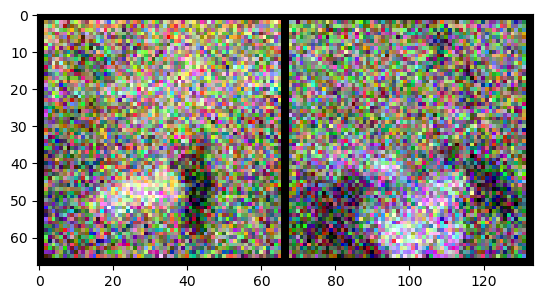

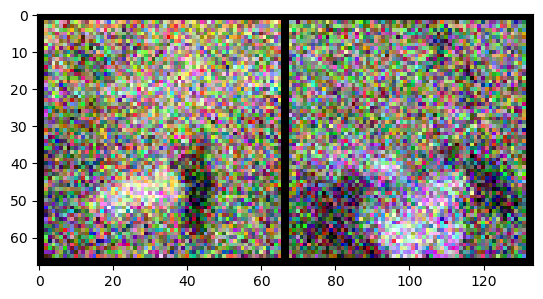

In [73]:
image, _ = next(iter(dataloader_train))

# -------------------------------------------------------------------
# Applied degradation
# -------------------------------------------------------------------
image_noise = degradation_func(image)

image       = image.to(device)
image_noise = image_noise.to(device)

# -------------------------------------------------------------------
# Y0 generation identity, gaussian distribution, zero
# -------------------------------------------------------------------
prediction = generate_Y0(image_noise, 'id')
# prediction.requires_grad = True

update = nn.Parameter(prediction, requires_grad=True)


# -------------------------------------------------------------------
# Yn generation
# -------------------------------------------------------------------
energy.eval()

for _ in range(2):
  loss = - energy(update)
  loss = loss.mean()
  loss.backward()
  
  update.data -= 0.5 * list_lr_langevin[0] * update.grad
  
  update.data = update.data + 0.5 * np.sqrt(list_lr_langevin[0]) * torch.randn_like(update)
  
  update.data = torch.clamp(update.data, *scale_range)
  update.grad.detach_()
  update.grad.zero_()
  plt.imshow(torchvision.utils.make_grid(update[1:3].detach().cpu(), nrow=2, normalize=True).permute(1,2,0))
  plt.show()

In [121]:
random.randrange(args.batch_size)

57

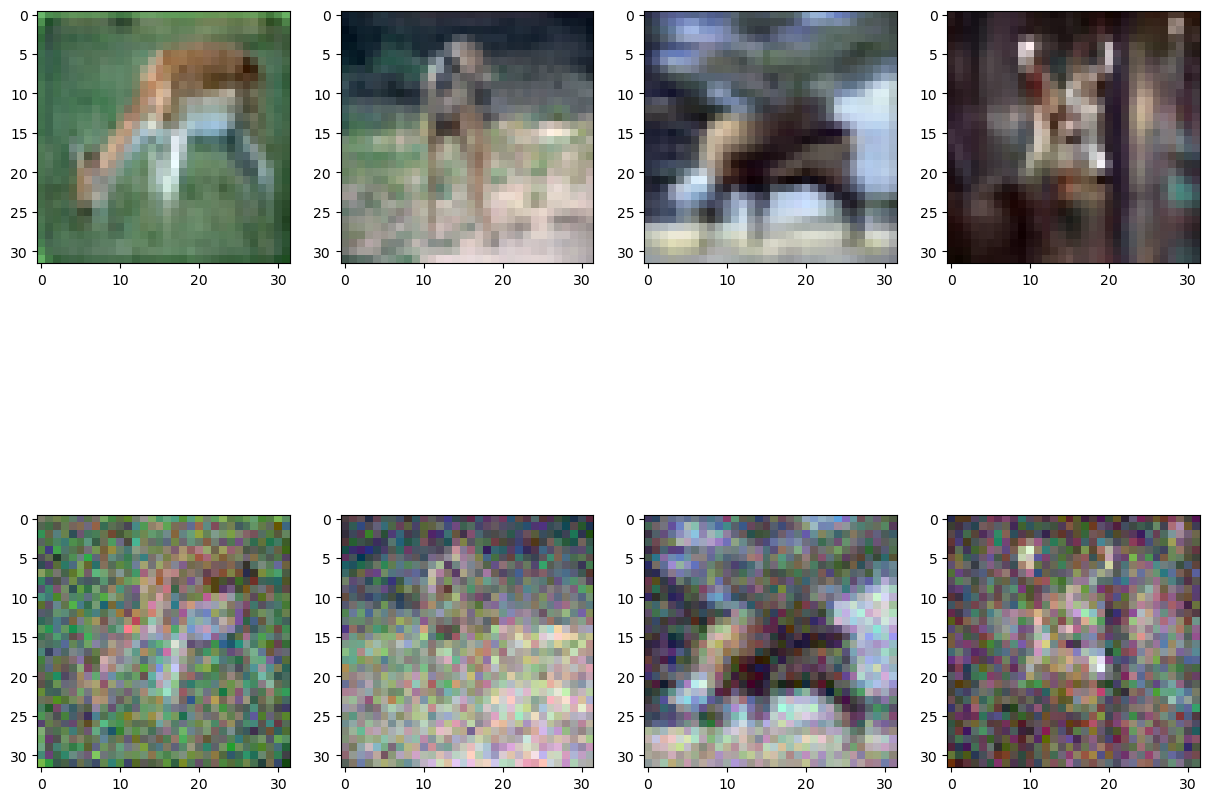

In [26]:
a, _ =next(iter(dataloader_train))

b = degradation_func(a)

fig, ax = plt.subplots(2,4 , figsize = (3 * 5, 3 * 4))
for i in range(4):
    ax[0][i].imshow(torchvision.utils.make_grid(a[i], normalize=True).permute(1,2,0))
    ax[1][i].imshow(torchvision.utils.make_grid(b[i], normalize=True).permute(1,2,0))
plt.show()    

MNIST:
 [   0/ 100]  [L_ebm=-12028.5667 | LR_ebm=0.00010 | PSNR_Y0=3.3798 | PSNR_Y:10=3.37979]
MNIST:
 [   1/ 100]  [L_ebm=-24999.5547 | LR_ebm=0.00010 | PSNR_Y0=3.2114 | PSNR_Y:10=3.21137]
MNIST:
 [   2/ 100]  [L_ebm=-40349.5919 | LR_ebm=0.00010 | PSNR_Y0=3.1314 | PSNR_Y:10=3.13137]
MNIST:
 [   3/ 100]  [L_ebm=-58494.2630 | LR_ebm=0.00010 | PSNR_Y0=3.0227 | PSNR_Y:10=3.02270]
MNIST:
 [   4/ 100]  [L_ebm=-79573.9884 | LR_ebm=0.00010 | PSNR_Y0=2.8105 | PSNR_Y:10=2.81052]
MNIST:
 [   5/ 100]  [L_ebm=-103595.7116 | LR_ebm=0.00010 | PSNR_Y0=2.8994 | PSNR_Y:10=2.89936]
MNIST:
 [   6/ 100]  [L_ebm=-130640.7602 | LR_ebm=0.00010 | PSNR_Y0=2.9656 | PSNR_Y:10=2.96560]
MNIST:
 [   7/ 100]  [L_ebm=-160776.2209 | LR_ebm=0.00010 | PSNR_Y0=2.9089 | PSNR_Y:10=2.90886]
MNIST:
 [   8/ 100]  [L_ebm=-194085.2697 | LR_ebm=0.00010 | PSNR_Y0=2.7943 | PSNR_Y:10=2.79433]
MNIST:
 [   9/ 100]  [L_ebm=-230618.9324 | LR_ebm=0.00010 | PSNR_Y0=2.8178 | PSNR_Y:10=2.81777]
MNIST:
 [  10/ 100]  [L_ebm=-270455.0679 | LR

KeyboardInterrupt: 

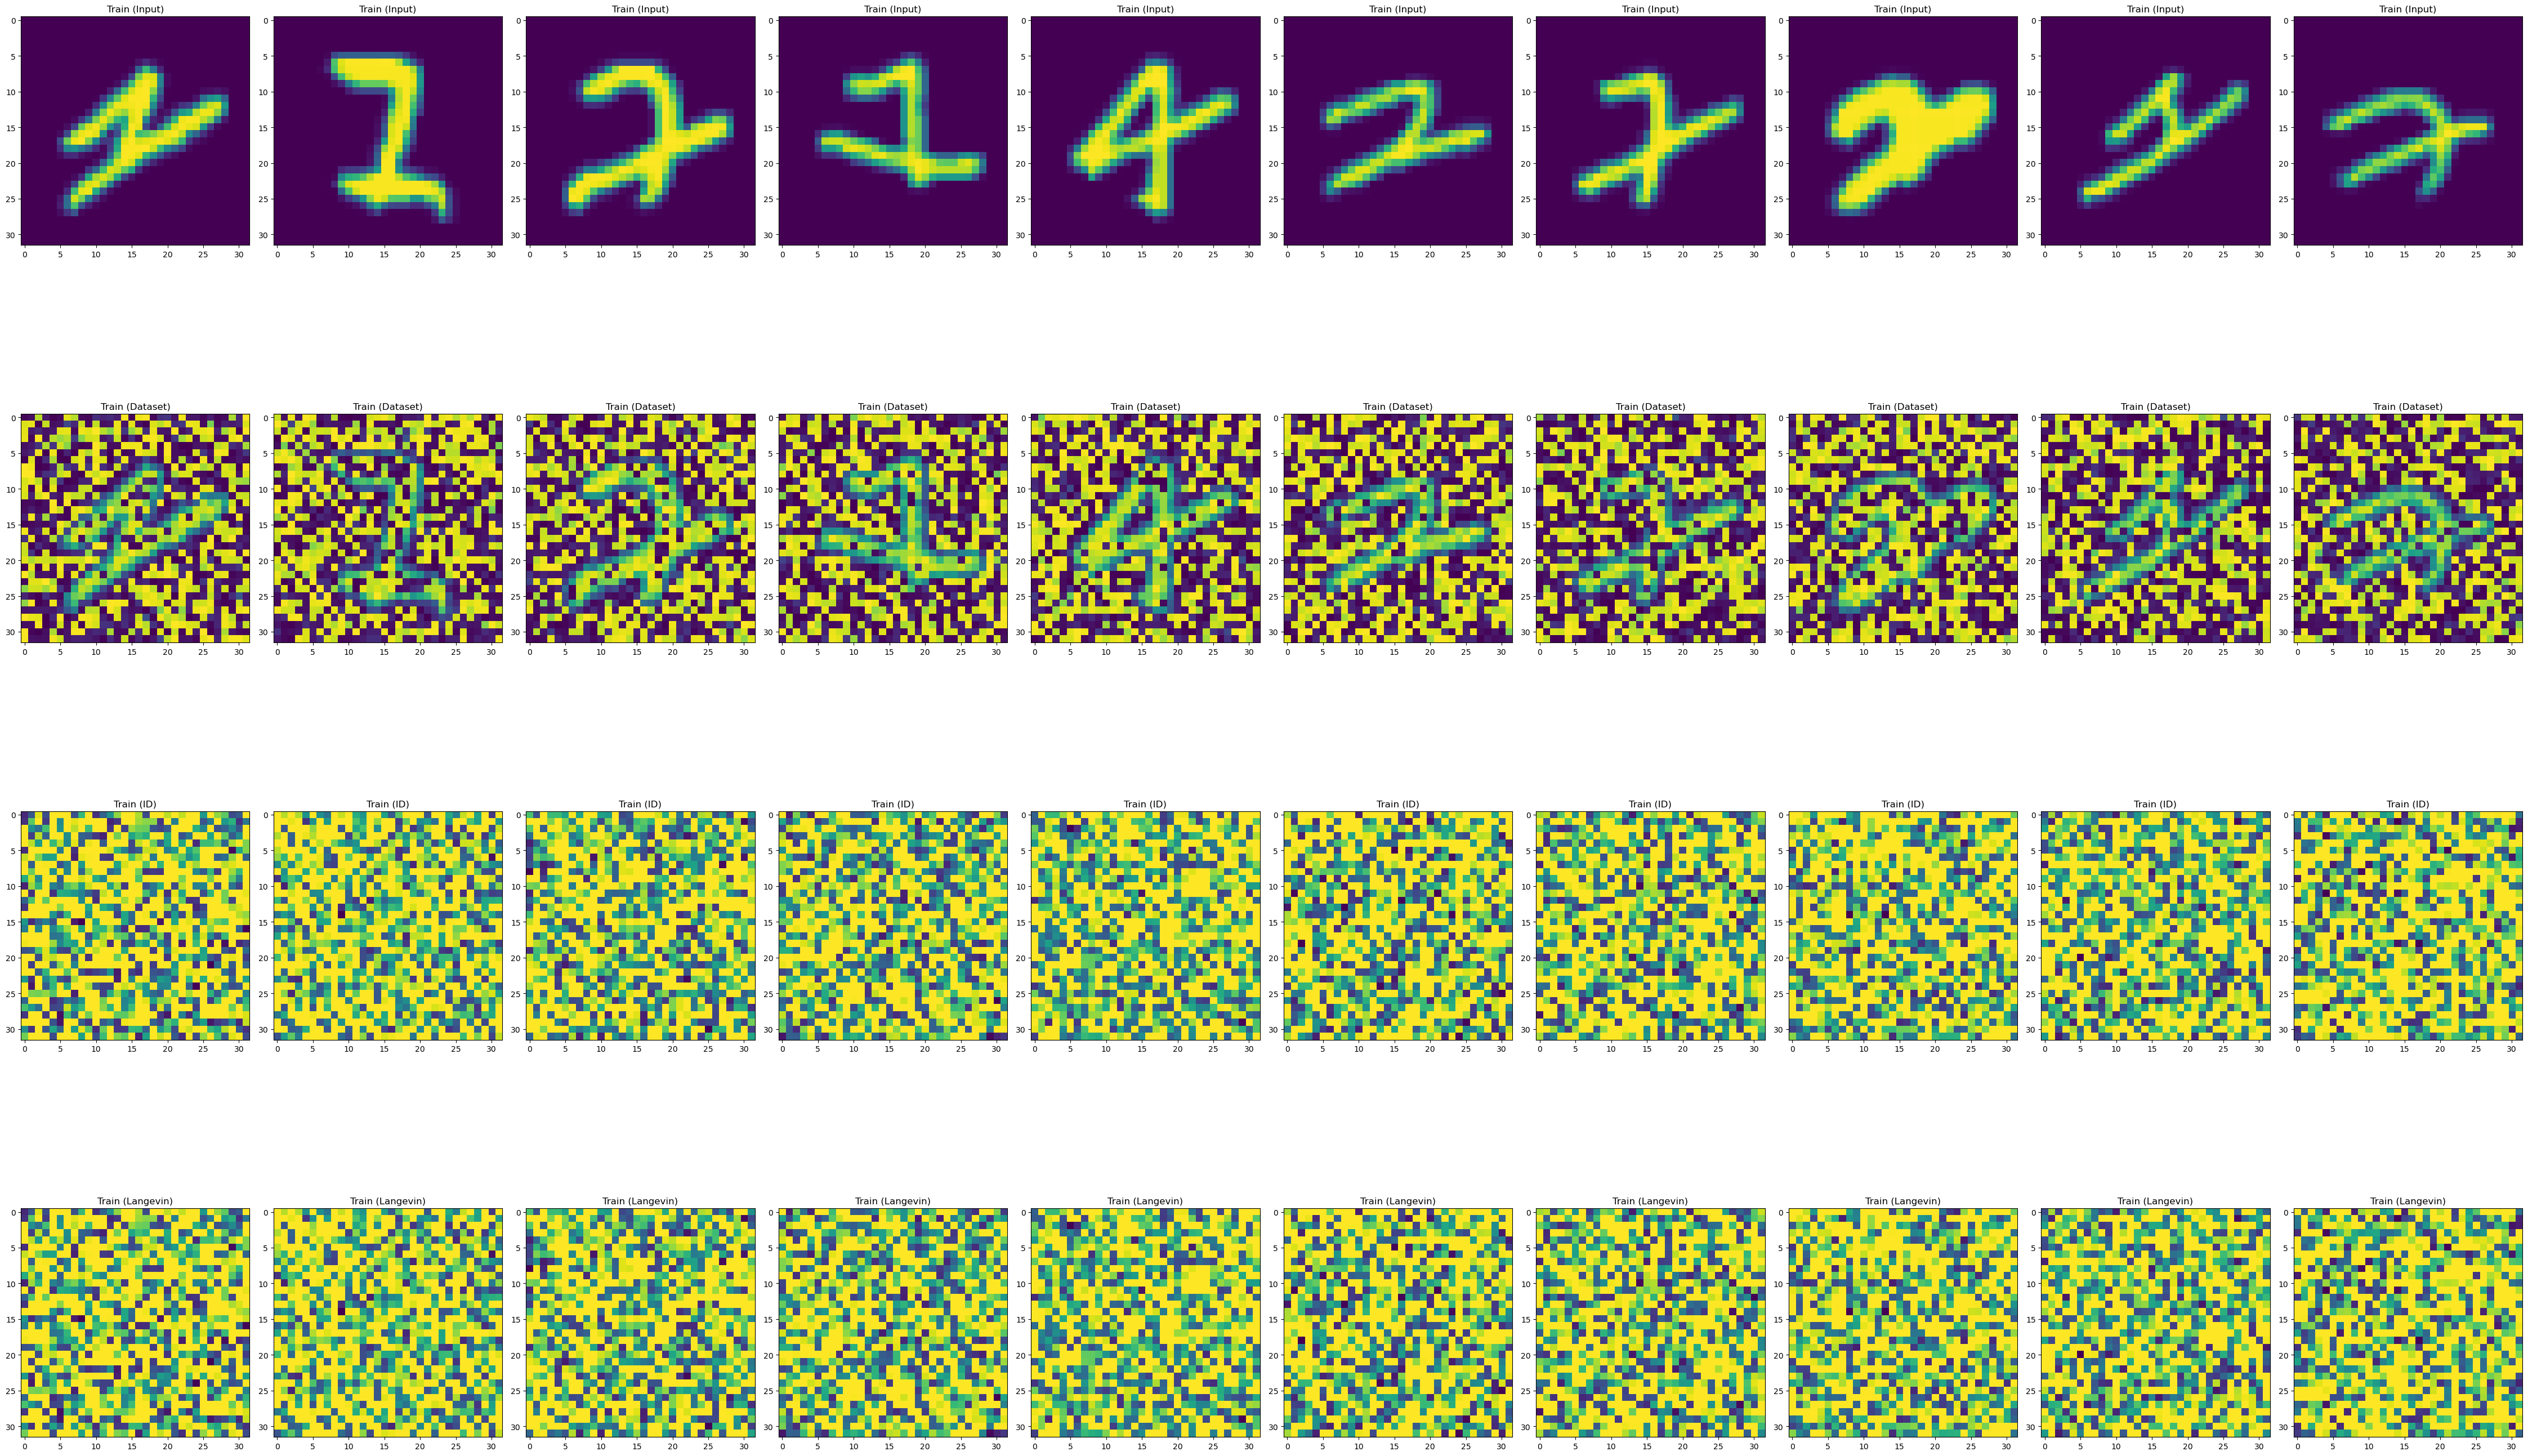

In [39]:
# ======================================================================
# Training
# ======================================================================
samples=list()

for i in range(number_epoch):
  val_loss_energy_model = list()
  val_psnr              = list()
  val_psnr_langevin     = list()

  for j, (image, _) in enumerate(iter(dataloader_train)):
    # -------------------------------------------------------------------
    # Applied degradation
    # -------------------------------------------------------------------
    if use_unpaired:
      image, image2 = torch.split(image, batch_size)
      image2_noise  = degradation_func(image2)
      image2        = image2.to(device)
      image2_noise  = image2_noise.to(device)

    else:
      image_noise = degradation_func(image)

    image       = image.to(device)
    image_noise = image_noise.to(device)

    # -------------------------------------------------------------------
    # Y0 generation identity, gaussian distribution, zero
    # -------------------------------------------------------------------
    if len(samples) < 1:
      prediction = generate_Y0(image, 'random')
    else:
      rand_ = random.choices(samples)
      prediction = torch.stack(rand_, dim=0)[0]
    # -------------------------------------------------------------------
    # Yn generation
    # -------------------------------------------------------------------
    energy.eval()
    
    prediction_update = energy.update_prediction_langevin(image_noise, 
                                                        prediction.detach(), 
                                                        number_step_langevin,  
                                                        list_lr_langevin[i], 
                                                        regular_data, 
                                                        add_noise, 
                                                        init_noise_decay)
    # -------------------------------------------------------------------
    # EBM gradient evaluation
    # -------------------------------------------------------------------
    energy = energy.train()
    optim_energy.zero_grad()
    if use_unpaired:
      loss_energy = energy.compute_loss(image2_noise, image2, image_noise, prediction_update.detach())
    else:
      loss_energy = energy.compute_loss(image_noise, image, image_noise, prediction_update.detach())

    loss_energy.backward()

    value_psnr          = to_numpy(PSNR(prediction, image))
    value_psnr_langevin = to_numpy(PSNR(prediction_update, image))

    samples.append(prediction_update)
    # -------------------------------------------------------------------
    # Update networks
    # -------------------------------------------------------------------
    optim_energy.step()

    # -------------------------------------------------------------------
    # Save results for each batch iteration
    # -------------------------------------------------------------------        
    val_loss_energy_model.append(loss_energy.item())
    val_psnr.append(value_psnr)
    val_psnr_langevin.append(value_psnr_langevin)
  
  if len(samples) > 8192:
    samples = samples[-8192:]
  # -------------------------------------------------------------------
  # Update schedulers
  # -------------------------------------------------------------------
  lr_energy_model = sched_optim_energy.get_last_lr()[0]

  if use_energy_sched:
    sched_optim_energy.step()

  # -------------------------------------------------------------------
  # Save results for each epoch
  # -------------------------------------------------------------------
  val_loss_energy_model_mean[i] = np.mean(val_loss_energy_model)
  val_loss_energy_model_std[i]  = np.std(val_loss_energy_model)
  val_psnr_mean[i]              = np.mean(val_psnr)
  val_psnr_std[i]               = np.std(val_psnr)
  val_psnr_langevin_mean[i]     = np.mean(val_psnr_langevin)
  val_psnr_langevin_std[i]      = np.std(val_psnr_langevin)

  log = Self_Energy_log(number_step_langevin) % (i, 
                                                  number_epoch, 
                                                  val_loss_energy_model_mean[i], 
                                                  lr_energy_model, 
                                                  val_psnr_mean[i], 
                                                  val_psnr_langevin_mean[i])
  print(f"{name}:\n", log)
  if i % args.save_plot == (args.save_plot) -1:
    energy.eval()
    fig, ax = plt.subplots(4, 10, figsize = (3 * 15, 3 * 10))
    for k in range(10):
      rand = random.randrange(len(dataloader_train))
      ax[0][k].set_title('Train (Input)')
      ax[0][k].imshow((tr(vis_im_transform((image[k,...]).detach().cpu().numpy()))* 255).astype(np.uint8))
      ax[1][k].set_title('Train (Dataset)')
      ax[1][k].imshow((tr(vis_im_transform((image_noise[k,...]).detach().cpu().numpy()))*255).astype(np.uint8))
      ax[2][k].set_title('Train (ID)')
      ax[2][k].imshow((tr(vis_im_transform((prediction[k,...]).detach().cpu().numpy()))*255).astype(np.uint8))
      ax[3][k].set_title('Train (Langevin)')
      ax[3][k].imshow((tr(vis_im_transform((prediction_update[k,...]).detach().cpu().numpy()))*255).astype(np.uint8))
    time_ = datetime.datetime.now().strftime('%H_%M')

    plt.tight_layout()
    fig.savefig(f'{date_figure}/log_epoch:{i}_{time_}.png', bbox_inches='tight', dpi=300)
    plt.close(fig)
  # TODO: find a condition to break the loop
  # if np.isnan(val_psnr_mean[i]) or ((i > 10) and (val_psnr_mean[i] < 5)) or ((i > 100) and (val_psnr_mean[i] < 10)):
  #   print(f'Terminating the run after {i} epochs..')
  #   break
    


In [ ]:
# ======================================================================
# Model evaluation for inferences
# ======================================================================
energy = energy.eval()

# ======================================================================
# Training results
# ======================================================================
(image_train, _) = next(iter(dataloader_train))
image_noise_train = degradation_func(image_train)
image_train       = image_train.to(device)
image_noise_train = image_noise_train.to(device)
y_train           = generate_Y0(image_noise_train, Y0_type)
y_update_train    = energy.update_prediction_langevin(image_noise_train, 
                                                      y_train.detach(), 
                                                      number_step_langevin, 
                                                      list_lr_langevin[-1], 
                                                      regular_data, 
                                                      add_noise, 
                                                      init_noise_decay)

image_train       = to_numpy(permute(image_train)).squeeze()
image_noise_train = to_numpy(permute(image_noise_train)).squeeze()
y_train           = to_numpy(permute(y_train)).squeeze()
y_update_train    = to_numpy(permute(y_update_train)).squeeze()

# -------------------------------------------------------------------
# Training performance measuring
# -------------------------------------------------------------------
train_self_data_psnr     = np.zeros(len(dataloader_train))
train_energy_data_psnr = np.zeros(len(dataloader_train))

for i, (image_train_, _) in enumerate(iter(dataloader_train)):
  image_noise_train_ = degradation_func(image_train_)
  image_train_       = image_train_.to(device)
  image_noise_train_ = image_noise_train_.to(device)
  y_train_           = generate_Y0(image_noise_train_, Y0_type)
  y_update_train_    = energy.update_prediction_langevin(image_noise_train_, 
                                                         y_train_.detach(), 
                                                         number_step_langevin, 
                                                         list_lr_langevin[-1], 
                                                         regular_data, 
                                                         add_noise, 
                                                         init_noise_decay)

  train_self_data_psnr[i]     = to_numpy(PSNR(y_train_, image_train_)).mean()
  train_energy_data_psnr[i] = to_numpy(PSNR(y_update_train_, image_train_)).mean()

# ======================================================================
# Testing results
# ======================================================================
(image_test, _) = next(iter(dataloader_test))
image_noise_test = degradation_func(image_test)
image_test       = image_test.to(device)
image_noise_test = image_noise_test.to(device)
y_test           = generate_Y0(image_noise_test, Y0_type)
y_update_test    = energy.update_prediction_langevin(image_noise_test, 
                                                     y_test.detach(), 
                                                     number_step_langevin, 
                                                     list_lr_langevin[-1], 
                                                     regular_data, 
                                                     add_noise, 
                                                     init_noise_decay)

image_test       = to_numpy(permute(image_test)).squeeze()
image_noise_test = to_numpy(permute(image_noise_test)).squeeze()
y_test           = to_numpy(permute(y_test)).squeeze()
y_update_test    = to_numpy(permute(y_update_test)).squeeze()

# -------------------------------------------------------------------
# Testing performance measuring
# -------------------------------------------------------------------
test_self_data_psnr     = np.zeros(len(dataloader_test))
test_energy_data_psnr = np.zeros(len(dataloader_test))

for i, (image_test_, _) in enumerate(iter(dataloader_test)):
  image_noise_test_ = degradation_func(image_test_)
  image_test_       = image_test_.to(device)
  image_noise_test_ = image_noise_test_.to(device)
  y_test_           = generate_Y0(image_noise_test_, Y0_type)
  y_update_test_    = energy.update_prediction_langevin(image_noise_test_, 
                                                        y_test_.detach(), 
                                                        number_step_langevin, 
                                                        list_lr_langevin[-1], 
                                                        regular_data, 
                                                        add_noise, 
                                                        init_noise_decay)

  test_self_data_psnr[i]     = to_numpy(PSNR(y_test_, image_test_)).mean()
  test_energy_data_psnr[i] = to_numpy(PSNR(y_update_test_, image_test_)).mean()

# -------------------------------------------------------------------
# Save models
# -------------------------------------------------------------------
torch.save(energy, energy_file_model)

# -------------------------------------------------------------------
# Save the options
# -------------------------------------------------------------------
with open(file_option, 'w') as f:
  f.write('{}: {}\n'.format('work directory', dir_work))
  f.write('{}: {}\n'.format('cuda device', cuda_device))
  f.write('{}: {}\n'.format('seed', seed))
  f.write('{}: {}\n'.format('dataset', dir_dataset))
  f.write('{}: {}\n'.format('Y0 type', Y0_type))
  f.write('{}: {}\n'.format('image size', im_size))
  f.write('{}: {}\n'.format('scale range', scale_range))
  f.write('{}: {}\n'.format('train size', train_size))
  f.write('{}: {}\n'.format('test size', test_size))
  f.write('{}: {}\n'.format('use subset', use_subset))
  f.write('{}: {}\n'.format('use label', use_label))
  f.write('{}: {}\n'.format('batch size', batch_size))
  f.write('{}: {}\n'.format('number epoch', number_epoch))
  f.write('{}: {}\n'.format('use energy scheduler', use_energy_sched))
  f.write('{}: {}\n'.format('scheduler step size', sched_step_size))
  f.write('{}: {}\n'.format('scheduler gamma', sched_gamma))
  f.write('{}: {}\n'.format('lr energy model', lr_energy_model))
  f.write('{}: {}\n'.format('lr langevin max', lr_langevin_max))
  f.write('{}: {}\n'.format('lr langevin min', lr_langevin_min))
  f.write('{}: {}\n'.format('number step langevin', number_step_langevin))
  f.write('{}: {}\n'.format('regular data', regular_data))
  f.write('{}: {}\n'.format('langevin noise decay factor', init_noise_decay))
  f.write('{}: {}\n'.format('use energy weights regularization', use_reg))
  f.write('{}: {}\n'.format('energy weights regularization weight', reg_weight))
  f.write('{}: {}\n'.format('use energy L2 weights regularization', use_L2_reg))
  f.write('{}: {}\n'.format('energy L2 weights regularization weight', L2_reg_weight))
  f.write('{}: {}\n'.format('add noise', add_noise))
  f.write('{}: {}\n'.format('use unpaired', use_unpaired))
  f.write('{}: {}\n'.format('sigma noise', sigma_noise))
  f.write('{}: {}\n'.format('salt and pepper noise', snp_noise))
  f.write('{}: {}\n'.format('delete square pixels', square_pixels))
  f.write('{}: {}\n'.format('degradation', degradation))
  f.write('{}: {}\n'.format('in channel', in_channel))
  f.write('{}: {}\n'.format('dim feature', dim_feature))
  f.write('{}: {}\n'.format('dim output', dim_output))
  f.write('{}: {}\n'.format('train id psnr mean', np.mean(train_self_data_psnr)))
  f.write('{}: {}\n'.format('train id psnr std', np.std(train_self_data_psnr)))
  f.write('{}: {}\n'.format('train energy psnr mean', np.mean(train_energy_data_psnr)))
  f.write('{}: {}\n'.format('train energy psnr std', np.std(train_energy_data_psnr)))
  f.write('{}: {}\n'.format('test id psnr mean', np.mean(test_self_data_psnr)))
  f.write('{}: {}\n'.format('test id psnr std', np.std(test_self_data_psnr)))
  f.write('{}: {}\n'.format('test energy psnr mean', np.mean(test_energy_data_psnr)))
  f.write('{}: {}\n'.format('test energy psnr std', np.std(test_energy_data_psnr)))

f.close()

# -------------------------------------------------------------------
# Save the results
# -------------------------------------------------------------------   
with open(file_result, 'w', newline='') as f:
  writer = csv.writer(f, delimiter=',')
  writer.writerow(val_loss_energy_model_mean)
  writer.writerow(val_loss_energy_model_std)
  writer.writerow(val_psnr_mean)
  writer.writerow(val_psnr_std)
  writer.writerow(val_psnr_langevin_mean)
  writer.writerow(val_psnr_langevin_std)
  writer.writerow(train_self_data_psnr)
  writer.writerow(train_energy_data_psnr)
  writer.writerow(test_self_data_psnr)
  writer.writerow(test_energy_data_psnr)

f.close()

# -------------------------------------------------------------------
# Save the figures from training
# -------------------------------------------------------------------
nRow  = 9
nCol  = 5
fSize = 3

fig, ax = plt.subplots(nRow, nCol, figsize=(fSize * nCol, fSize * nRow))

ax[0][0].set_title('Energy Model')
ax[0][0].plot(val_loss_energy_model_mean, color='red', label='Loss')
ax[0][0].legend()

ax[0][1].set_title('Train PSNR')
ax[0][1].plot(val_psnr_mean, color='red', label='ID')
ax[0][1].plot(val_psnr_langevin_mean, color='green', label='Langevin')
ax[0][1].legend()

bplot_colors = ['pink', 'lightgreen']

ax[0][2].set_title('ID Data PSNR')
ax[0][2].yaxis.grid(True)
bplot0 = ax[0][2].boxplot([train_self_data_psnr, 
                           test_self_data_psnr], 0, vert=True, patch_artist=True, labels=['Train', 'Test'])
for patch, color in zip(bplot0['boxes'], bplot_colors):
  patch.set_facecolor(color)

ax[0][3].set_title('Energy Data PSNR')
ax[0][3].yaxis.grid(True)
bplot1 = ax[0][3].boxplot([train_energy_data_psnr, 
                           test_energy_data_psnr], 0, vert=True, patch_artist=True, labels=['Train', 'Test'])
for patch, color in zip(bplot1['boxes'], bplot_colors):
  patch.set_facecolor(color)

for i in range(nCol):
  ax[1][i].set_title('Train (Input)')
  if in_channel == 1:
    ax[1][i].imshow(vis_im_transform(image_noise_train[i, ...]), cmap='gray')
  else:
    ax[1][i].imshow(vis_im_transform(image_noise_train[i, ...]))

for i in range(nCol):
  ax[2][i].set_title('Train (Dataset)')
  if in_channel == 1:
    ax[2][i].imshow(vis_im_transform(image_train[i, ...]), cmap='gray')
  else:
    ax[2][i].imshow(vis_im_transform(image_train[i, ...]))

for i in range(nCol):
  ax[3][i].set_title('Train (ID)')
  if in_channel == 1:
    ax[3][i].imshow(vis_im_transform(y_train[i, ...]), cmap='gray')
  else:
    ax[3][i].imshow(vis_im_transform(y_train[i, ...]))

for i in range(nCol):
  ax[4][i].set_title('Train (Langevin)')
  if in_channel == 1:
    ax[4][i].imshow(vis_im_transform(y_update_train[i, ...]), cmap='gray')
  else:
    ax[4][i].imshow(vis_im_transform(y_update_train[i, ...]))

for i in range(nCol):
  ax[5][i].set_title('Test (Input)')
  if in_channel == 1:
    ax[5][i].imshow(vis_im_transform(image_noise_test[i, ...]), cmap='gray')
  else:
    ax[5][i].imshow(vis_im_transform(image_noise_test[i, ...]))

for i in range(nCol):
  ax[6][i].set_title('Test (Dataset)')
  if in_channel == 1:
    ax[6][i].imshow(vis_im_transform(image_test[i, ...]), cmap='gray')
  else:
    ax[6][i].imshow(vis_im_transform(image_test[i, ...]))

for i in range(nCol):
  ax[7][i].set_title('Test (ID)')
  if in_channel == 1:
    ax[7][i].imshow(vis_im_transform(y_test[i, ...]), cmap='gray')
  else:
    ax[7][i].imshow(vis_im_transform(y_test[i, ...]))

for i in range(nCol):
  ax[8][i].set_title('Test (Langevin)')
  if in_channel == 1:
    ax[8][i].imshow(vis_im_transform(y_update_test[i, ...]), cmap='gray')
  else:
    ax[8][i].imshow(vis_im_transform(y_update_test[i, ...]))

plt.tight_layout()
fig.savefig(file_figure, bbox_inches='tight', dpi=600)
plt.close(fig)